# Michaelis-Menten kinetics dynamics

### The Michaelis-Menten kinetics is given by the following system of (coupled) ordinary differential equations (ODEs):

$$
\dot{x}^{(\nu)}_i = -x^{(\nu)}_i + \sum_j w_{i,j} \cdot \frac{x^{(\nu)}_j}{1 + x^{(\nu)}_j}, \quad i, j \in \{1, \dots, N\}
$$

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint  # Import the odeint function from scipy for solving ODEs

In [26]:
# This function returns the derivative of the state vector expressed according to the formula mentioned above.
# x is the "function" (state vector) we wish to solve for.
def ode_system(x, t, W): # t must be passed even if not used
    N = len(x) # Get the number of elements in the state vector
    derivative_vector = np.zeros(N) # Initialize the derivative vector (set zeros as default)
    for i in range(N):  # Loop over each element in the state vector
        # Compute the sum term for the i-th element according to the formula given in the paper (list comprehension ftw 😎)
        sum_term = sum(W[i, j] * (x[j] / (1 + x[j])) for j in range(N))
        derivative_vector[i] = -x[i] + sum_term
    return derivative_vector

In [27]:
# Initialize parameters
N = 200  # Set the number of elements in the state vector
vector = np.random.rand(N) # Create a random initial state vector with values between 0 and 1 (this is our synthetic data - just randomized data since this way we don't assume anything about the data)
W = np.random.uniform(0, 2, (N, N))  # Create a random weight matrix with values uniformly distributed between 0 and 2 (as specified in the paper)

# Set up the time points for the simulation
# doesn't really matter but necessary for the odeint function
t = np.linspace(0, 6, 1000)  # Create an array of 1000 time points from 0 to 6 (0, 0.006, 0.012, ..., 6)

In [28]:
# Run the simulation using the odeint function
# we can think of the ode_system as a function that returns the expression of the derivative,
# the vector as the initial condition (y_0),
# the time t as the parameter of the function (x(t)),
# and W as another parameter of the function (x(t, W)).
result = odeint(ode_system, vector, t, args=(W,)) # Solve the ODE system (calculate x(t) from the given dx/dt expression in the ode_system)

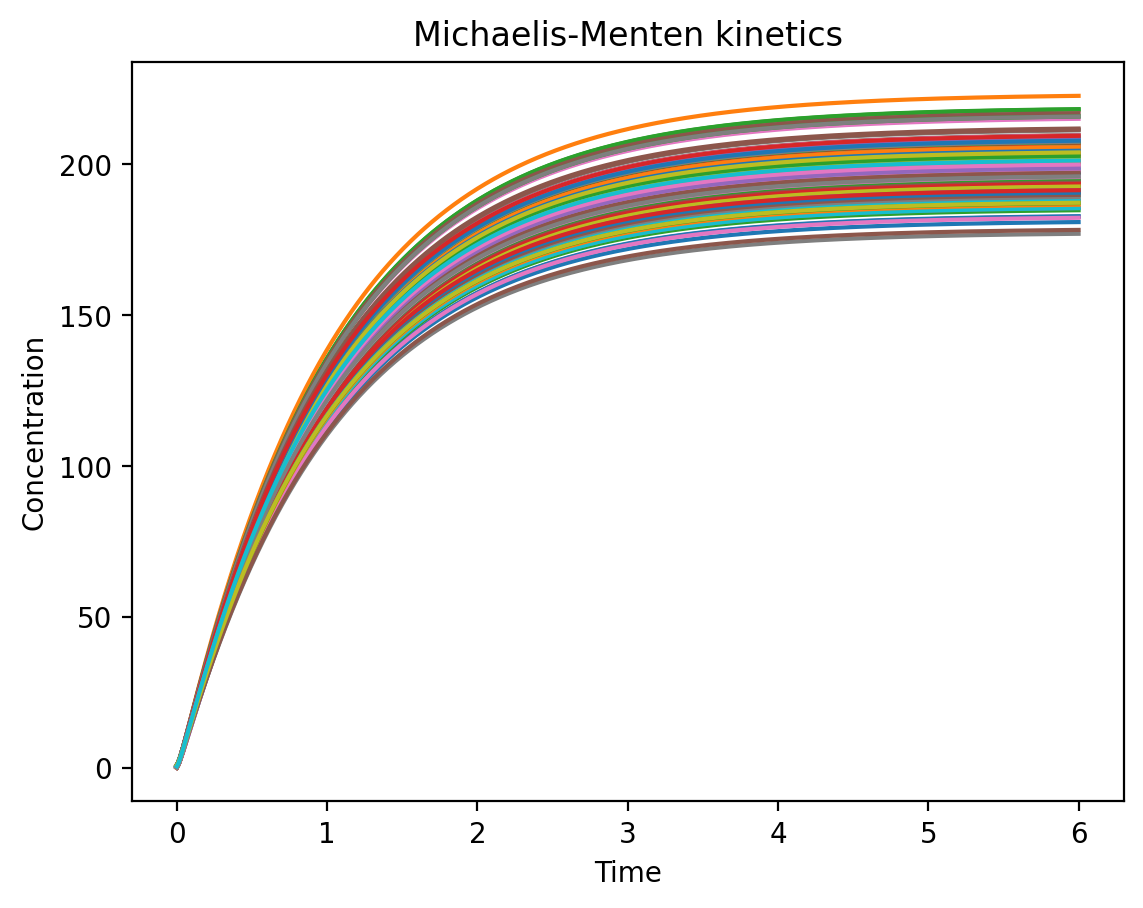

In [29]:
# Plot the results
for i in range(N):
    plt.plot(t, result[:, i], label=f'x_{i}')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Michaelis-Menten kinetics')
plt.show()